In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [3]:
# === 1. Load GSE132044 Mouse Cortex Data ===
print("=== Loading GSE132044 Mouse Cortex Data ===")

# File paths (modify based on your actual download path)
data_dir = "D:/Columbia/Courses/Fall 2025/GR5243 APPLIED DATA SCIENCE/Final Project/"

# Load expression matrix
print("1. Reading expression matrix...")
counts = sc.read_mtx(data_dir + "GSE132044_cortex_mm10_count_matrix.mtx.gz")

# Load gene information
print("2. Reading gene information...")
genes = pd.read_csv(data_dir + "GSE132044_cortex_mm10_gene.tsv.gz", 
                   sep='\t', header=None, names=['gene_id', 'gene_name'])

# Load cell information
print("3. Reading cell information...")
cells = pd.read_csv(data_dir + "GSE132044_cortex_mm10_cell.tsv.gz", 
                   sep='\t', header=None, names=['cell_barcode'])

# Create AnnData object
print("4. Creating AnnData object...")
adata = sc.AnnData(X=counts.X.T)  # Transpose to cells x genes
adata.var_names = genes['gene_name'].values
adata.obs_names = cells['cell_barcode'].values

# Add gene ID information
adata.var['gene_id'] = genes['gene_id'].values

print(f"Data loading complete: {adata.n_obs} cells, {adata.n_vars} genes")

=== Loading GSE132044 Mouse Cortex Data ===
1. Reading expression matrix...
2. Reading gene information...
3. Reading cell information...
4. Creating AnnData object...
Data loading complete: 15175 cells, 28692 genes


In [ ]:
# === Debug: Check Data Structure ===
print("=== Debug: Checking Data Structure ===")
print(f"adata type: {type(adata)}")
print(f"adata shape: {adata.shape}")
print(f"adata.obs_names type: {type(adata.obs_names)}")
print(f"First few obs_names: {list(adata.obs_names[:5])}")
print(f"adata.obs shape: {adata.obs.shape}")

# Let's see what the actual barcode format looks like
sample_barcodes = list(adata.obs_names[:10])
print("\nSample barcodes:")
for barcode in sample_barcodes:
    print(f"  {barcode}")
    parts = barcode.split('.')
    print(f"    Parts: {parts}")

=== Debug: Checking Data Structure ===
adata type: <class 'anndata._core.anndata.AnnData'>
adata shape: (15175, 28692)
adata.obs_names type: <class 'pandas.core.indexes.base.Index'>
First few obs_names: ['Cortex1.Smart-seq2.p1_A1', 'Cortex1.Smart-seq2.p2_A12', 'Cortex1.Smart-seq2.p2_A2', 'Cortex1.Smart-seq2.p2_A4', 'Cortex1.Smart-seq2.p2_A5']
adata.obs shape: (15175, 2)

Sample barcodes:
  Cortex1.Smart-seq2.p1_A1
    Parts: ['Cortex1', 'Smart-seq2', 'p1_A1']
  Cortex1.Smart-seq2.p2_A12
    Parts: ['Cortex1', 'Smart-seq2', 'p2_A12']
  Cortex1.Smart-seq2.p2_A2
    Parts: ['Cortex1', 'Smart-seq2', 'p2_A2']
  Cortex1.Smart-seq2.p2_A4
    Parts: ['Cortex1', 'Smart-seq2', 'p2_A4']
  Cortex1.Smart-seq2.p2_A5
    Parts: ['Cortex1', 'Smart-seq2', 'p2_A5']
  Cortex1.Smart-seq2.p2_A7
    Parts: ['Cortex1', 'Smart-seq2', 'p2_A7']
  Cortex1.Smart-seq2.p1_A8
    Parts: ['Cortex1', 'Smart-seq2', 'p1_A8']
  Cortex1.Smart-seq2.p2_B10
    Parts: ['Cortex1', 'Smart-seq2', 'p2_B10']
  Cortex1.Smart-seq2.

In [12]:
# === 2. Parse Cell Metadata (Fixed for Actual Barcode Format) ===
print("\n=== Parsing Cell Metadata ===")

# Extract technology platform and experiment batch from barcodes
tech_platform = []
experiment_batch = []

print("Parsing cell barcodes...")
for barcode in adata.obs_names:
    parts = barcode.split('.')
    if len(parts) >= 3:
        # Experiment batch is the first part (e.g., "Cortex1")
        experiment = parts[0]
        # Technology platform is the second part (e.g., "Smart-seq2")
        technology = parts[1]
        
        tech_platform.append(technology)
        experiment_batch.append(experiment)
    else:
        print(f"Warning: Unexpected barcode format: {barcode}")
        tech_platform.append('unknown')
        experiment_batch.append('unknown')

# Add to observation data
adata.obs['technology'] = tech_platform
adata.obs['experiment'] = experiment_batch


=== Parsing Cell Metadata ===
Parsing cell barcodes...



=== Quality Control ===
QC metrics statistics:
Mean genes per cell: 1980.6
Mean UMI counts per cell: 52190.2


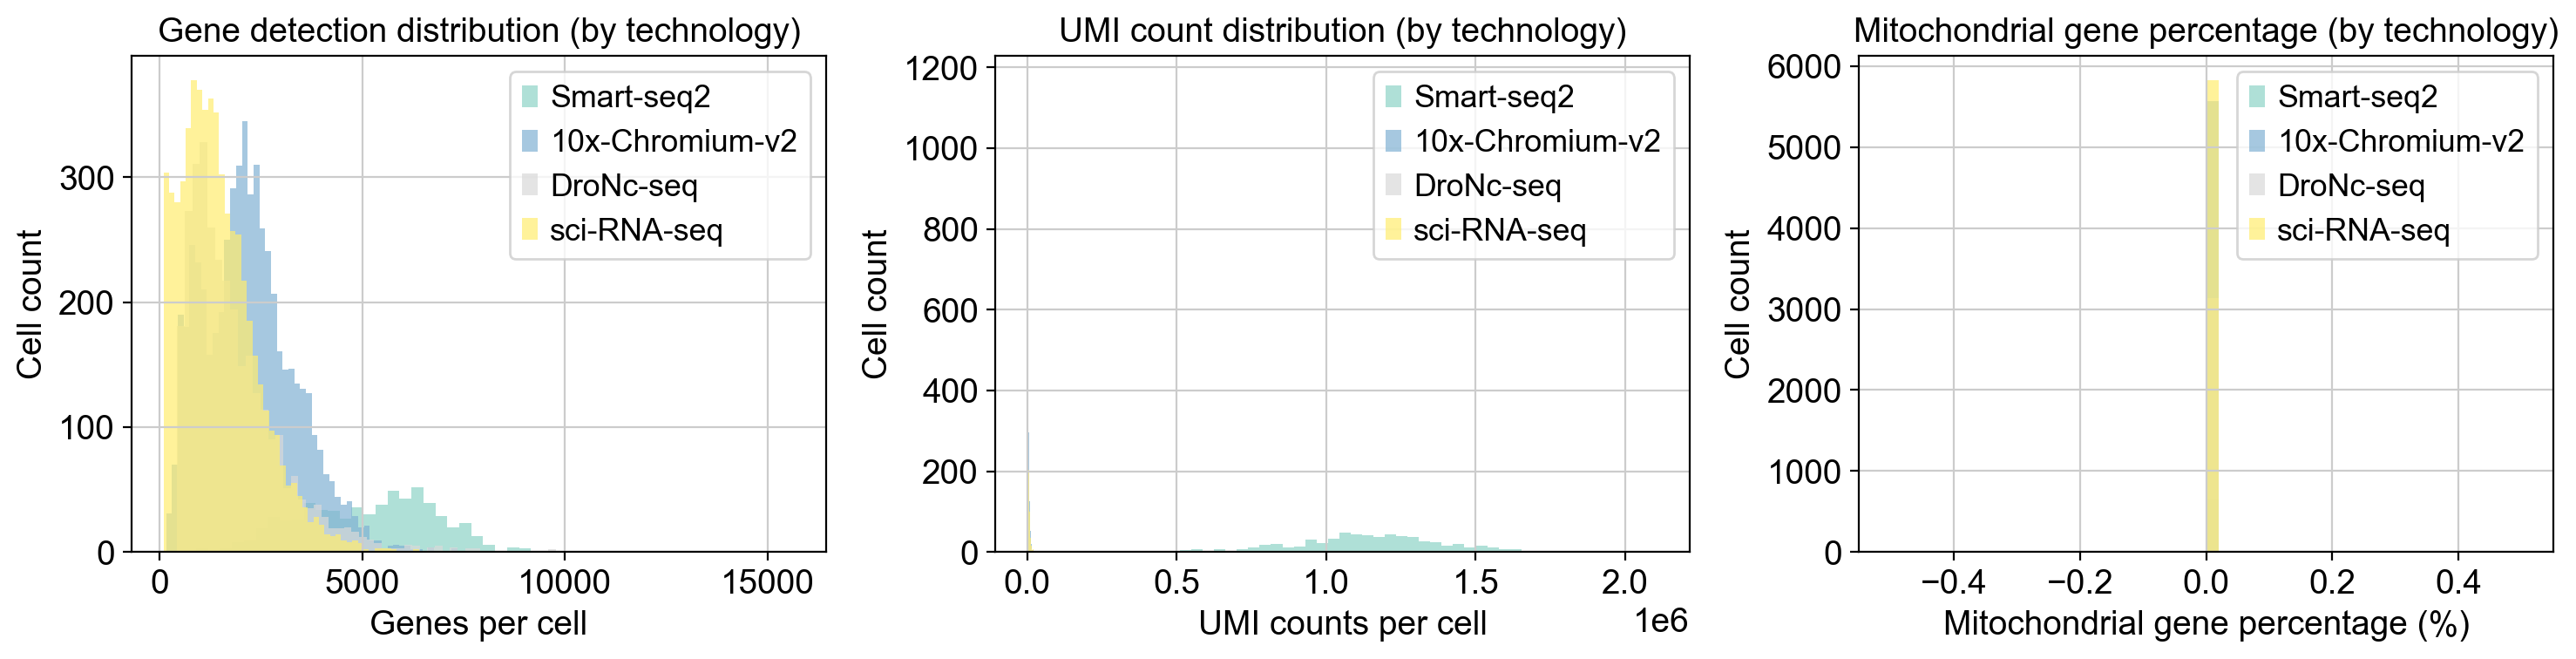

In [14]:
# === 3. Quality Control ===
print("\n=== Quality Control ===")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

print("QC metrics statistics:")
print(f"Mean genes per cell: {adata.obs['n_genes_by_counts'].mean():.1f}")
print(f"Mean UMI counts per cell: {adata.obs['total_counts'].mean():.1f}")

# Plot QC metrics by technology
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

technologies = adata.obs['technology'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(technologies)))

# Genes per cell by technology
for i, tech in enumerate(technologies):
    tech_data = adata.obs[adata.obs['technology'] == tech]['n_genes_by_counts']
    axes[0].hist(tech_data, bins=50, alpha=0.7, label=tech, color=colors[i])
axes[0].set_xlabel('Genes per cell')
axes[0].set_ylabel('Cell count')
axes[0].legend()
axes[0].set_title('Gene detection distribution (by technology)')

# UMI counts per cell by technology
for i, tech in enumerate(technologies):
    tech_data = adata.obs[adata.obs['technology'] == tech]['total_counts']
    axes[1].hist(tech_data, bins=50, alpha=0.7, label=tech, color=colors[i])
axes[1].set_xlabel('UMI counts per cell')
axes[1].set_ylabel('Cell count')
axes[1].legend()
axes[1].set_title('UMI count distribution (by technology)')

# Mitochondrial gene percentage
adata.var_names = adata.var_names.astype(str)
adata.var['mt'] = adata.var_names.str.startswith('mt-') | adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

for i, tech in enumerate(technologies):
    tech_data = adata.obs[adata.obs['technology'] == tech]['pct_counts_mt']
    axes[2].hist(tech_data, bins=50, alpha=0.7, label=tech, color=colors[i])
axes[2].set_xlabel('Mitochondrial gene percentage (%)')
axes[2].set_ylabel('Cell count')
axes[2].legend()
axes[2].set_title('Mitochondrial gene percentage (by technology)')

plt.tight_layout()
plt.show()

In [16]:
# === 4. Filter Low-Quality Cells and Genes ===
print("\n=== Filtering Low-Quality Cells and Genes ===")

# Set filtering thresholds
min_genes = 200
max_genes = 5000
max_mt_percent = 10

print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Filter cells
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, max_genes=max_genes)
adata = adata[adata.obs['pct_counts_mt'] < max_mt_percent].copy()

# Filter genes (expressed in at least 3 cells)
sc.pp.filter_genes(adata, min_cells=3)

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Show cell counts per technology after filtering
print("\nCell counts per technology after filtering:")
print(adata.obs['technology'].value_counts())


=== Filtering Low-Quality Cells and Genes ===
Before filtering: 14931 cells, 24719 genes
After filtering: 14409 cells, 24124 genes

Cell counts per technology after filtering:
technology
sci-RNA-seq        5581
10x-Chromium-v2    5480
DroNc-seq          3065
Smart-seq2          283
Name: count, dtype: int64



=== Exploring Technical Differences ===
Quality metrics by technology platform:
                n_genes_by_counts           total_counts             \
                             mean      std          mean        std   
technology                                                            
10x-Chromium-v2           2179.62  1051.71  4.499230e+03    2868.30   
DroNc-seq                 1749.66   974.94  3.107900e+03    2430.86   
Smart-seq2                3629.72   863.90  1.005280e+06  258135.13   
sci-RNA-seq               1506.50   900.66  3.406330e+03    3112.81   

                pct_counts_mt       
                         mean  std  
technology                          
10x-Chromium-v2           0.0  0.0  
DroNc-seq                 0.0  0.0  
Smart-seq2                0.0  0.0  
sci-RNA-seq               0.0  0.0  


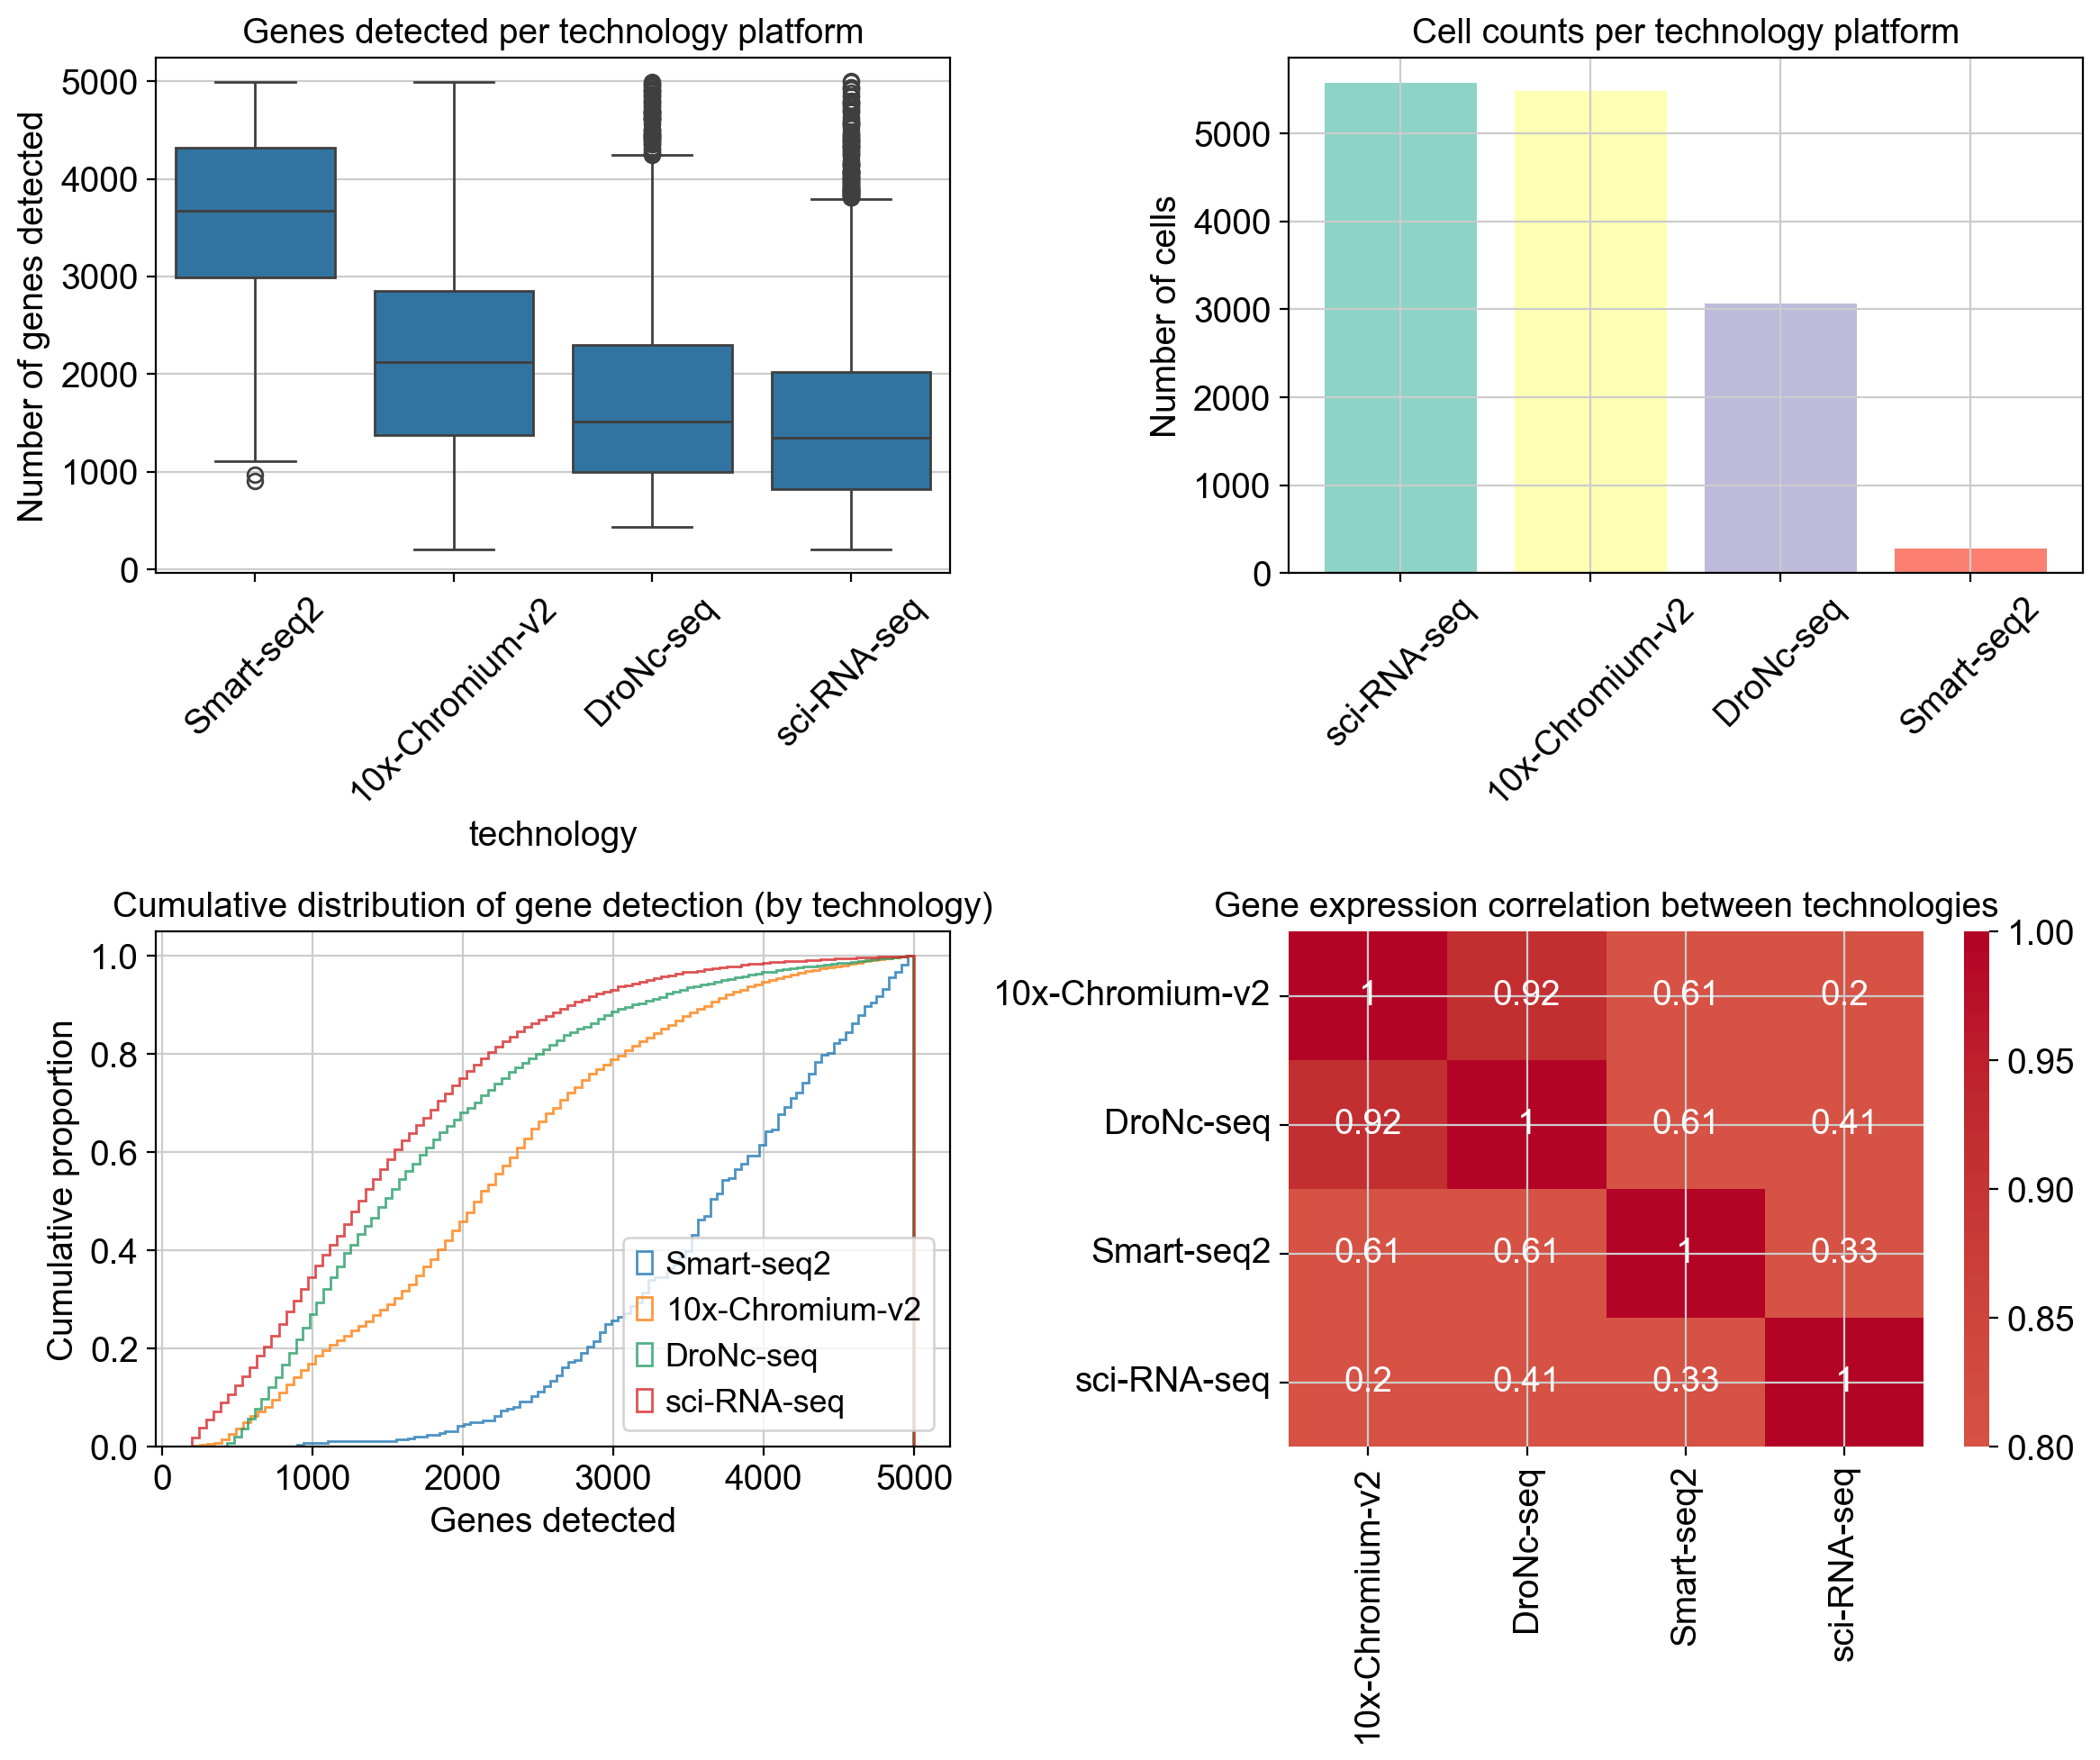

In [ ]:
# === 5. Explore Technical Differences ===
print("\n=== Exploring Technical Differences ===")

# Calculate statistics per technology
tech_stats = adata.obs.groupby('technology').agg({
    'n_genes_by_counts': ['mean', 'std'],
    'total_counts': ['mean', 'std'],
    'pct_counts_mt': ['mean', 'std']
}).round(2)

print("Quality metrics by technology platform:")
print(tech_stats)

# Plot technology comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Boxplot of genes detected per technology
tech_order = adata.obs.groupby('technology')['n_genes_by_counts'].median().sort_values(ascending=False).index
sns.boxplot(data=adata.obs, x='technology', y='n_genes_by_counts', order=tech_order, ax=axes[0,0])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[0,0].set_title('Genes detected per technology platform')
axes[0,0].set_ylabel('Number of genes detected')

# 2. Cell counts per technology
cell_counts = adata.obs['technology'].value_counts()
axes[0,1].bar(cell_counts.index, cell_counts.values, color=plt.cm.Set3(np.arange(len(cell_counts))))
axes[0,1].set_xticklabels(cell_counts.index, rotation=45)
axes[0,1].set_title('Cell counts per technology platform')
axes[0,1].set_ylabel('Number of cells')

# 3. Cumulative distribution of genes detected
for tech in adata.obs['technology'].unique():
    tech_data = adata.obs[adata.obs['technology'] == tech]['n_genes_by_counts']
    axes[1,0].hist(tech_data, bins=100, density=True, histtype='step', 
                  cumulative=True, label=tech, alpha=0.8)
axes[1,0].set_xlabel('Genes detected')
axes[1,0].set_ylabel('Cumulative proportion')
axes[1,0].set_title('Cumulative distribution of gene detection (by technology)')
axes[1,0].legend()

# 4. Correlation between technologies (sampling for large datasets)
if adata.n_obs > 10000:
    # Sample large datasets
    np.random.seed(42)
    sample_idx = np.random.choice(adata.n_obs, size=10000, replace=False)
    adata_sampled = adata[sample_idx].copy()
else:
    adata_sampled = adata.copy()

# Calculate highly variable genes
sc.pp.highly_variable_genes(adata_sampled, n_top_genes=2000, flavor='seurat_v3')

# Group by technology and calculate mean expression
tech_groups = adata_sampled.obs.groupby('technology').groups
tech_means = {}

for tech, indices in tech_groups.items():
    if len(indices) > 10:  # Ensure sufficient cells
        tech_means[tech] = np.array(adata_sampled[indices].X.mean(axis=0)).flatten()

# Calculate correlation between technologies
if len(tech_means) > 1:
    tech_corr = pd.DataFrame(index=tech_means.keys(), columns=tech_means.keys())
    for tech1 in tech_means:
        for tech2 in tech_means:
            corr = np.corrcoef(tech_means[tech1], tech_means[tech2])[0,1]
            tech_corr.loc[tech1, tech2] = corr
    
    sns.heatmap(tech_corr.astype(float), annot=True, cmap='coolwarm', 
               center=0, ax=axes[1,1], vmin=0.8, vmax=1.0)
    axes[1,1].set_title('Gene expression correlation between technologies')

plt.tight_layout()
plt.show()


=== Basic UMAP Visualization ===
1. Data preprocessing...
2. PCA dimensionality reduction...
3. UMAP dimensionality reduction and visualization...


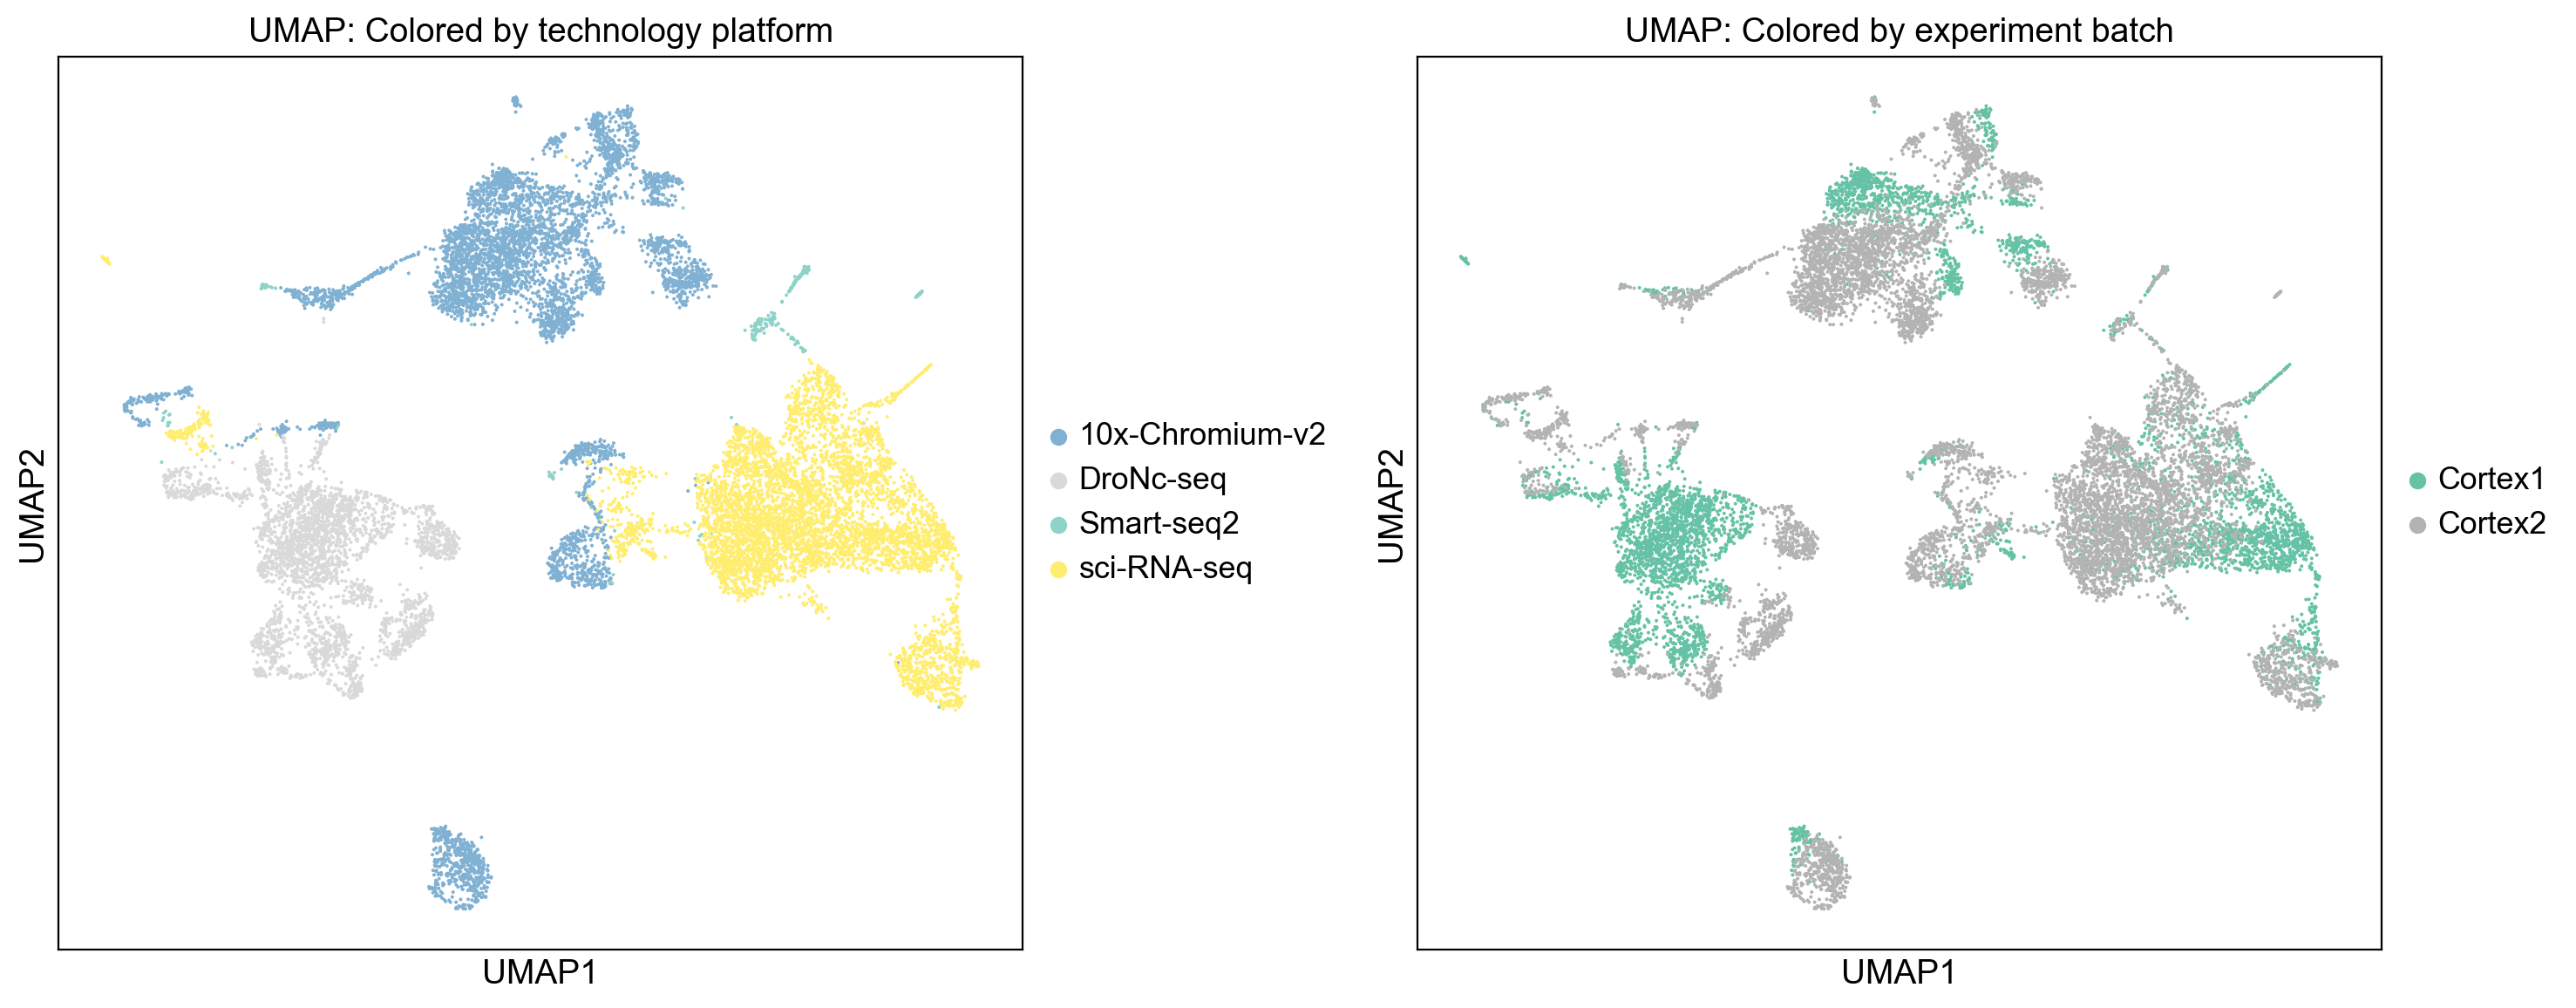


=== Alternative UMAP Visualization ===


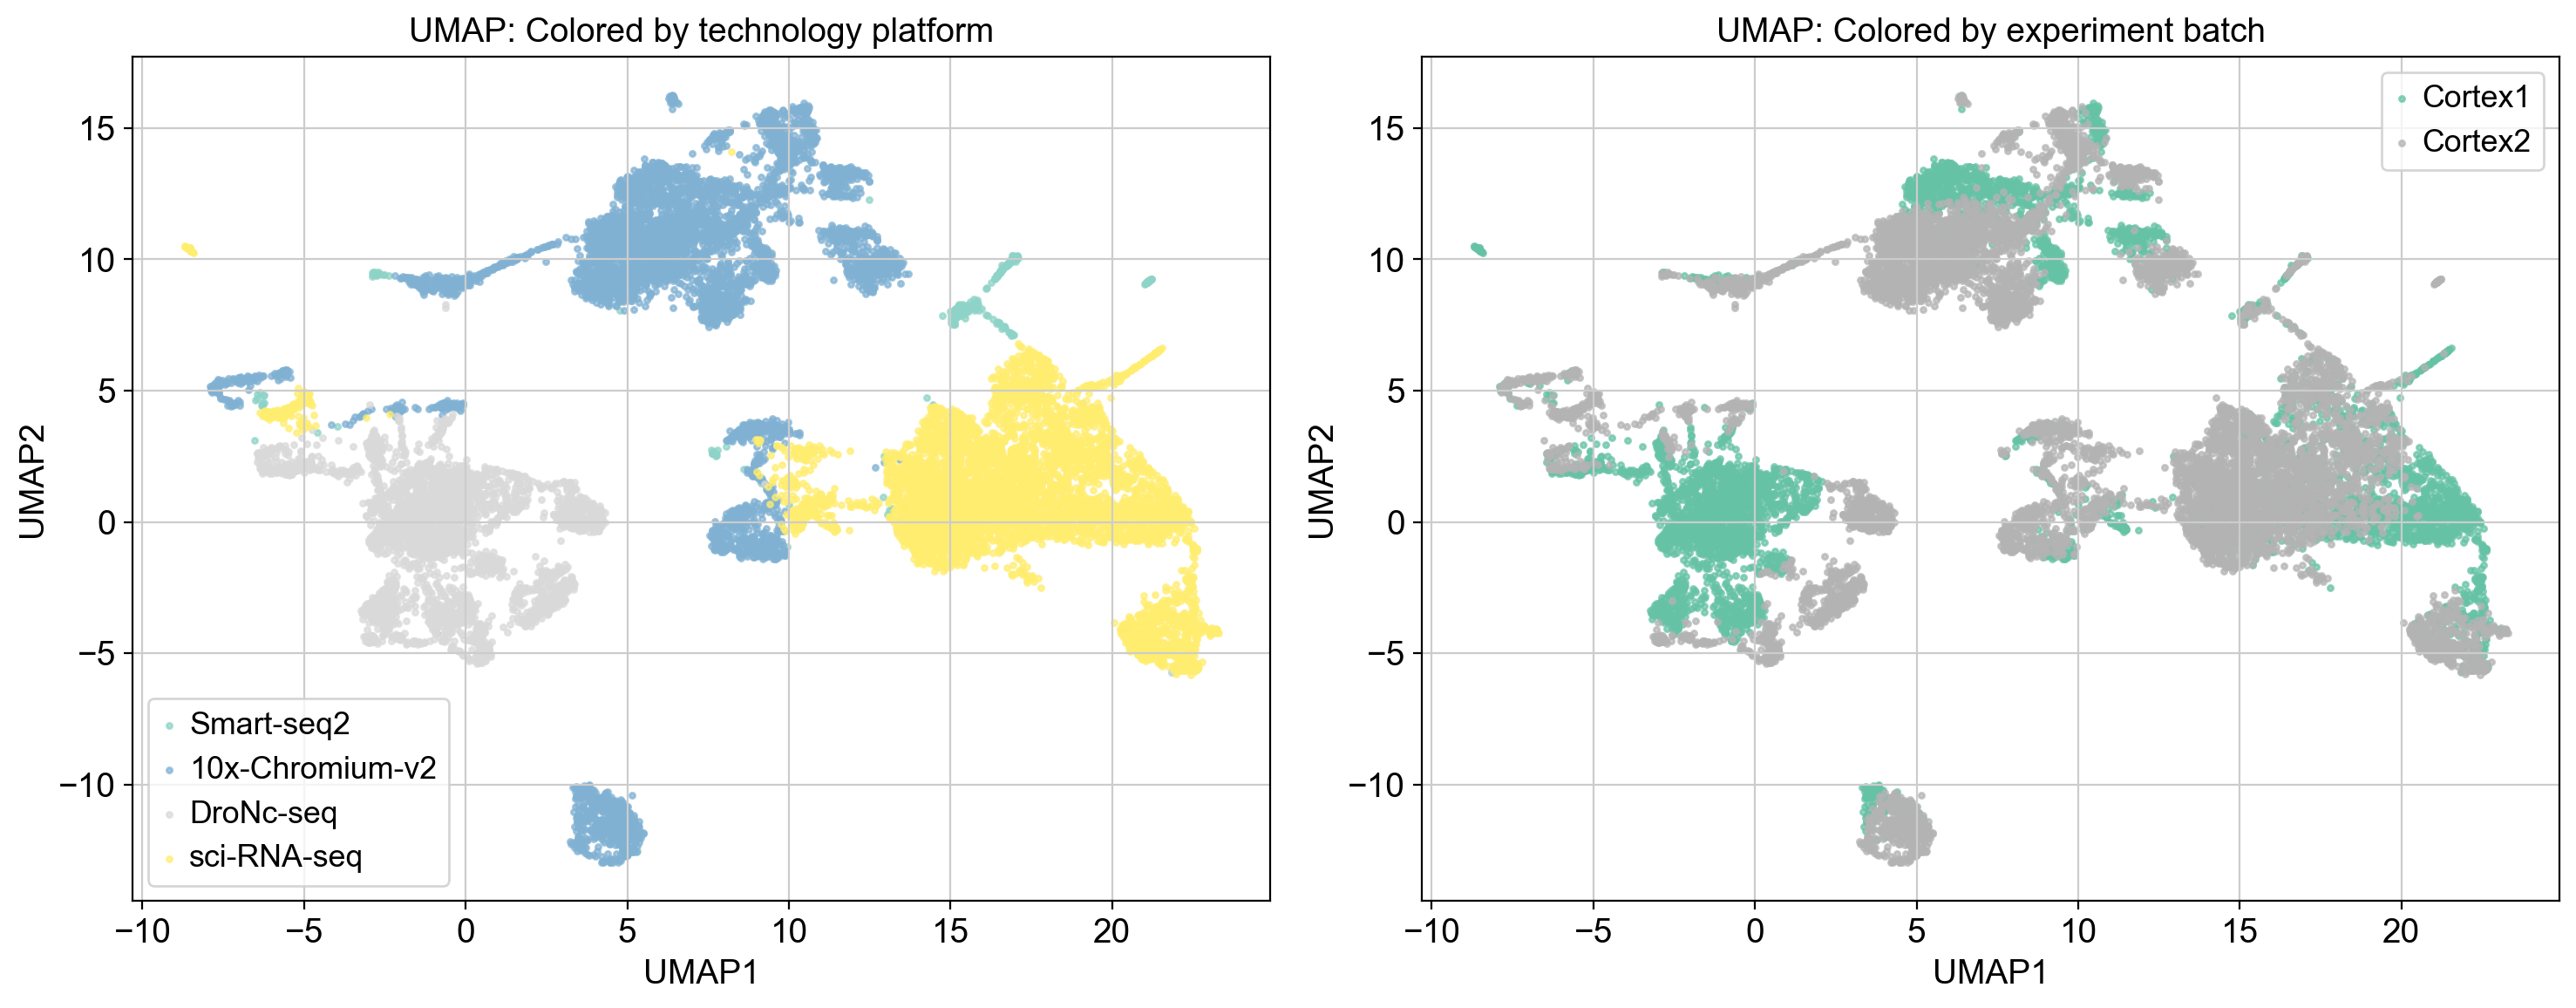


Technology distribution in UMAP space:
                 cell_count
technology                 
10x-Chromium-v2        5480
DroNc-seq              3065
Smart-seq2              283
sci-RNA-seq            5581


In [19]:
# === 6. Basic UMAP Visualization ===
print("\n=== Basic UMAP Visualization ===")

# Data preprocessing
print("1. Data preprocessing...")
adata_processed = adata.copy()

# Normalization
sc.pp.normalize_total(adata_processed, target_sum=1e4)
sc.pp.log1p(adata_processed)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_processed, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_processed = adata_processed[:, adata_processed.var.highly_variable]

# Scale data
sc.pp.scale(adata_processed, max_value=10)

# PCA dimensionality reduction
print("2. PCA dimensionality reduction...")
sc.tl.pca(adata_processed, svd_solver='arpack')

# UMAP visualization
print("3. UMAP dimensionality reduction and visualization...")
sc.pp.neighbors(adata_processed, n_pcs=30)
sc.tl.umap(adata_processed)

# Plot UMAP - FIXED VERSION
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Get unique categories for coloring
technologies = adata_processed.obs['technology'].unique()
experiments = adata_processed.obs['experiment'].unique()

# Create color palettes
tech_palette = {tech: color for tech, color in zip(technologies, plt.cm.Set3(np.linspace(0, 1, len(technologies))))}
exp_palette = {exp: color for exp, color in zip(experiments, plt.cm.Set2(np.linspace(0, 1, len(experiments))))}

# UMAP colored by technology - using the correct palette format
sc.pl.umap(adata_processed, color='technology', ax=axes[0], show=False, palette=tech_palette)
axes[0].set_title('UMAP: Colored by technology platform')

# UMAP colored by experiment batch - using the correct palette format
sc.pl.umap(adata_processed, color='experiment', ax=axes[1], show=False, palette=exp_palette)
axes[1].set_title('UMAP: Colored by experiment batch')

plt.tight_layout()
plt.show()

# Alternative UMAP visualization using matplotlib directly (more control)
print("\n=== Alternative UMAP Visualization ===")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Technology
for i, tech in enumerate(technologies):
    mask = adata_processed.obs['technology'] == tech
    axes[0].scatter(adata_processed.obsm['X_umap'][mask, 0], 
                   adata_processed.obsm['X_umap'][mask, 1],
                   c=[tech_palette[tech]], label=tech, s=5, alpha=0.7)
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')
axes[0].set_title('UMAP: Colored by technology platform')
axes[0].legend()

# Plot 2: Experiment
for i, exp in enumerate(experiments):
    mask = adata_processed.obs['experiment'] == exp
    axes[1].scatter(adata_processed.obsm['X_umap'][mask, 0], 
                   adata_processed.obsm['X_umap'][mask, 1],
                   c=[exp_palette[exp]], label=exp, s=5, alpha=0.7)
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')
axes[1].set_title('UMAP: Colored by experiment batch')
axes[1].legend()

plt.tight_layout()
plt.show()

# Show technology distribution in UMAP space
print("\nTechnology distribution in UMAP space:")
tech_umap_stats = adata_processed.obs.groupby('technology').agg({
    'technology': 'count'
}).rename(columns={'technology': 'cell_count'})
print(tech_umap_stats)

In [20]:
# === 7. Generate Summary Report ===
print("\n" + "="*50)
print("Phase 1 Summary Report")
print("="*50)

print(f"Dataset Overview:")
print(f"  - Total cells: {adata.n_obs}")
print(f"  - Total genes: {adata.n_vars}")
print(f"  - Number of technology platforms: {len(adata.obs['technology'].unique())}")
print(f"  - Number of experiment batches: {len(adata.obs['experiment'].unique())}")

print(f"\nTechnology Platform Cell Distribution:")
tech_counts = adata.obs['technology'].value_counts()
for tech, count in tech_counts.items():
    percentage = (count / adata.n_obs) * 100
    print(f"  - {tech}: {count} cells ({percentage:.1f}%)")

print(f"\nData Quality Metrics:")
print(f"  - Mean genes per cell: {adata.obs['n_genes_by_counts'].mean():.1f}")
print(f"  - Mean UMI counts per cell: {adata.obs['total_counts'].mean():.1f}")
print(f"  - Mean mitochondrial gene percentage: {adata.obs['pct_counts_mt'].mean():.2f}%")

print(f"\nTechnology Platform Differences:")
tech_means = adata.obs.groupby('technology')['n_genes_by_counts'].mean()
max_tech = tech_means.idxmax()
min_tech = tech_means.idxmin()
print(f"  - Highest gene detection: {max_tech} ({tech_means[max_tech]:.0f} genes)")
print(f"  - Lowest gene detection: {min_tech} ({tech_means[min_tech]:.0f} genes)")
print(f"  - Fold difference: {tech_means[max_tech]/tech_means[min_tech]:.1f}x")


Phase 1 Summary Report
Dataset Overview:
  - Total cells: 14409
  - Total genes: 24124
  - Number of technology platforms: 4
  - Number of experiment batches: 2

Technology Platform Cell Distribution:
  - sci-RNA-seq: 5581 cells (38.7%)
  - 10x-Chromium-v2: 5480 cells (38.0%)
  - DroNc-seq: 3065 cells (21.3%)
  - Smart-seq2: 283 cells (2.0%)

Data Quality Metrics:
  - Mean genes per cell: 1855.9
  - Mean UMI counts per cell: 23435.8
  - Mean mitochondrial gene percentage: 0.00%

Technology Platform Differences:
  - Highest gene detection: Smart-seq2 (3630 genes)
  - Lowest gene detection: sci-RNA-seq (1507 genes)
  - Fold difference: 2.4x
